# packages

In [2]:
from readlif.reader import LifFile
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)
from skimage.exposure import histogram

import cv2 as cv
from PIL import Image


# pre-request functions

In [3]:
def plot_hist(ax, data, title=None):
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    
    if title:
        ax.set_title(title)

# code

In [135]:
new = LifFile('Data/20220815 necroptosis Paula_PS-A2-60.lif')
img_list = [i for i in new.get_iter_image()]


In [136]:
m_values = [int(''.join(char for char in str(item).split("m=")[1].split(",")[0] if char.isdigit())) for item in img_list]

# Calculating the sum
sum_of_m_values = sum(m_values)

print("Sum of series:", sum_of_m_values)

Sum of series: 84


In [137]:
serie_number = None
while serie_number is None:
    try:
        serie_number = int(input("Please enter the serie number that you're interesting in: "))
    except ValueError:
        print("Invalid integer!")
        print(f"The integer you entered was {number_as_integer}")

# Extracting values after "m=" and accumulating until the sum reaches 4
selected_list = []
z_list = []
x_list = []
y_list = []
current_sum = 0

for item in img_list:
    m_value = int(''.join(char for char in str(item).split("m=")[1].split(",")[0] if char.isdigit()))
    z_value = int(''.join(char for char in str(item).split("z=")[1].split(",")[0] if char.isdigit()))
    x_value = int(''.join(char for char in str(item).split("x=")[1].split(",")[0] if char.isdigit()))
    y_value = int(''.join(char for char in str(item).split("y=")[1].split(",")[0] if char.isdigit()))

    if current_sum + m_value <= serie_number:
        selected_list.append(item)
        z_list.append(z_value)
        x_list.append(x_value)
        y_list.append(y_value)
        current_sum += m_value
        corrected_m = m_value
    else:
        if current_sum + m_value > serie_number & current_sum != serie_number:
            selected_list.append(item)
            z_list.append(z_value)
            x_list.append(x_value)
            y_list.append(y_value)
            current_sum += m_value
            corrected_m =m_value - (current_sum - serie_number)
        break

print("Selected List until the sum of seires " + str(serie_number) )

#for item in selected_list:
#    print(item)

print("The number of the image that you selected is at section", len(selected_list), "when the m = ", str(corrected_m), "when the z = ", str(z_list[-1]))#str(z_value[len(selected_list)]

Please enter the serie number that you're interesting in:  74


Selected List until the sum of seires 74
The number of the image that you selected is at section 49 when the m =  1 when the z =  34


# Try one image 

In [138]:
selected_image = selected_list[-1]
z_value = z_list[-1]
selected_image

frame = selected_image.get_frame(z=33, t=0, c=1)
image = np.array(frame)

print("shape: {}".format(image.shape))
print("dtype: {}".format(image.dtype))
print("range: ({}, {})".format(np.min(image), np.max(image)))

shape: (1024, 1024)
dtype: uint8
range: (0, 255)


# All z of the image

Those link might help
1. https://napari.org/stable/gallery.html#gallery (Examples of napari usage.)


In [139]:
selected_image = selected_list[-1]
z_value = z_list[-1]
z_values = np.arange(0, z_value)

x_value = x_list[-1]
x_values = np.arange(0, x_value)

y_value = y_list[-1]
y_values = np.arange(0, y_value)

merged_image = np.zeros((z_value, x_value, y_value), dtype=np.uint8)

# Load each image and assign it to the corresponding slice in the merged image array
for i in z_values:
    img = np.array(selected_image.get_frame(z=i, t=0, c=1))
    merged_image[i, :, :] = img

In [140]:
merged_image.shape

(34, 1024, 1024)

In [141]:
viewer = napari.view_image(merged_image)

# Marge image divide by 2,5,10

In [21]:
import math
import napari
from skimage import data

def merge_images(image_series, num_to_merge):
    num_images, height, width = image_series.shape
    merg_images = np.zeros((math.ceil(num_images/num_to_merge), height, width), dtype=np.uint8)
    count = 0
    for i in range(0, num_images, num_to_merge):
        end_index = min(i + num_to_merge, num_images)
        if i != end_index:
            for a in range (i,end_index):
                for x in range(0, height):
                    for y in range(0,width):
                        if merg_images[count][x][y] < image_series[a][x][y]:
                            merg_images[count][x][y] = image_series[a][x][y]
            count = count + 1 
        else:
            for a in range (i,num_images):
                for x in range(0, height):
                    for y in range(0,width):
                        if merg_images[count][x][y] < image_series[a][x][y]:
                            merg_images[count][x][y] = image_series[a][x][y]
            count = count + 1 
    napari.view_image(merg_images, name='Marge '+str(num_to_merge))
    return np.array(merg_images)


In [41]:
# Example usage:
series_2 = merge_images(merged_image, 2)
series_5 = merge_images(merged_image, 5)
series_10 = merge_images(merged_image, 10)

print(series_5.shape)

(7, 1024, 1024)


# Merge all image into one

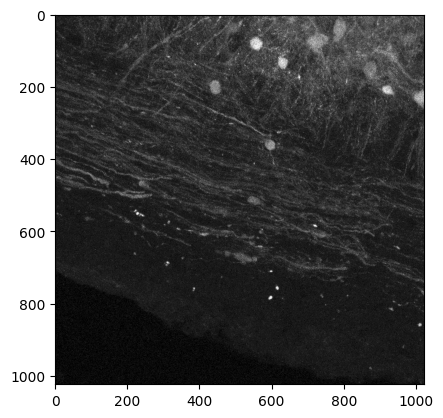

In [142]:
integrated_image = np.zeros((x_value, y_value), dtype=np.uint8)
for i in z_values:
    for x in x_values:
        for y in y_values:
            if integrated_image[x][y] < merged_image[i][x][y]:
                integrated_image[x][y] = merged_image[i][x][y]
plt.imshow(integrated_image, cmap = 'gray')

Do you want to crop the image? (y/n):  y


Script executed successfully.


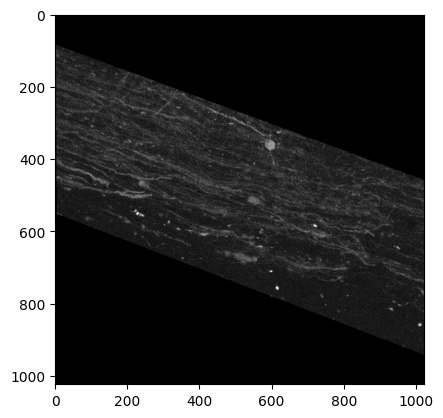

In [143]:
user_input = None
while user_input not in ['y', 'n','Y']:
    try:
        if user_input != None:
            print(f"The string you entered was {user_input}. Please try again.")
        user_input = input("Do you want to crop the image? (y/n): ")
    except ValueError:
        print("Invalid integer!")
        print(f"The string you entered was {user_input}. Please try again.")

        
if user_input.upper() == "Y":
    import subprocess
    from IPython.display import display, Image
    # Save the NumPy array as an image file
    image_path = "./integrated_image.jpg"  # Specify the desired path and file name
    cv.imwrite(image_path, integrated_image)

    # Call the capture_partial_image.py script with the image path
    script_path = "./capture_partial_image.py"  # Replace with the actual path
    subprocess.run(["python", script_path, "--image", image_path], check=True)

    cropped_image = cv.imread("./cropped_region.jpg")
    print("Script executed successfully.")
    
    from skimage.color import rgb2gray
    cropped_image = np.uint8(rgb2gray(cropped_image) * 255) 
    plt.imshow(cropped_image, cmap = 'grey')
    
    import os
    #s.remove(image_path)
    #os.remove("./cropped_region.jpg")
else:
    print("The image does not crop.")

In [52]:
def cropped_a_stack(image_series, mask):
    num_images, height, width = image_series.shape
    cropped_images = np.copy(image_series)
    for x in range(0, height):
        for y in range(0,width):
            if mask[x][y] == 0:
                for i in range(0,num_images):
                    image_series[i][x][y] = 0
    napari.view_image(cropped_images)
    return np.array(cropped_images)

In [54]:
crop_series_2 = cropped_a_stack(series_2, cropped_image)
crop_series_5 = cropped_a_stack(series_5, cropped_image)
crop_series_10 = cropped_a_stack(series_10, cropped_image)


# Pre-processing of images

In 8 bits image, 0 is black, 255 is white.

1. https://www.section.io/engineering-education/image-preprocessing-in-python/
interesting pre-processing:
    1. `Data augmentation`:
    Performing data augmentation helps in preventing a neural network from learning irrelevant features. This results in better model performance.
    2. `CLAHE` (Contrast Limited Adaptive Histogram Equalization):
    https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html

2. https://stackoverflow.com/questions/36711627/image-processing-issues-with-blood-vessels
3. http://scipy-lectures.org/advanced/image_processing/#denoising
4. https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
    1. Dilation could fix the broken parts of an object.
    
Resizing and Rescaling:

Library: OpenCV (cv2), Pillow (PIL)
Methods: cv2.resize(), PIL.Image.resize()
Usage: Adjust image dimensions and scale pixel values.

Normalization:

Library: scikit-image (skimage), OpenCV (cv2)
Methods: skimage.exposure.rescale_intensity(), cv2.normalize()
Usage: Normalize pixel values to a specific range for improved model training.

Grayscale Conversion:

Library: OpenCV (cv2), Pillow (PIL)
Methods: cv2.cvtColor(), PIL.Image.convert()
Usage: Convert color images to grayscale.

Histogram Equalization:

Library: scikit-image (skimage), OpenCV (cv2)
Methods: skimage.exposure.equalize_hist(), cv2.equalizeHist()
Usage: Enhance image contrast by equalizing pixel intensities.

Image Denoising:

Library: OpenCV (cv2), scikit-image (skimage)
Methods: cv2.fastNlMeansDenoising(), skimage.restoration.denoise_bilateral()
Usage: Remove noise from images.

Image Cropping:

Library: OpenCV (cv2), Pillow (PIL)
Methods: cv2.crop(), PIL.Image.crop()
Usage: Remove unwanted portions of the image.

Data Augmentation:

Library: Keras (keras.preprocessing.image), imgaug
Methods: ImageDataGenerator in Keras, imgaug library
Usage: Generate augmented images for improved model generalization.

Thresholding:

Library: OpenCV (cv2), scikit-image (skimage)
Methods: cv2.threshold(), skimage.filters.threshold_otsu()
Usage: Convert grayscale images to binary images based on intensity thresholds.

Edge Detection:

Library: OpenCV (cv2), scikit-image (skimage)
Methods: cv2.Canny(), skimage.feature.canny()
Usage: Detect edges in images.

Image Segmentation:

Library: OpenCV (cv2), scikit-image (skimage), scikit-learn (sklearn)
Methods: Various segmentation algorithms
Usage: Divide an image into meaningful segments.

Custom Preprocessing:

Library: NumPy, OpenCV (cv2), Pillow (PIL)
Usage: Implement custom preprocessing steps based on specific requirements.

## Try in one integrated image

### Try 1
https://stackoverflow.com/questions/36711627/image-processing-issues-with-blood-vessels

In [18]:
integrated_image.max()

255

(array([[   0.,    0.,    0., ...,    0.,    0., 1024.],
        [   0.,    0.,    0., ...,    0.,    0., 1024.],
        [   0.,    0.,    0., ...,    0.,    0., 1024.],
        ...,
        [  23.,   45.,   21., ...,    0.,    0.,  935.],
        [  10.,   26.,   14., ...,    0.,    0.,  974.],
        [   0.,    0.,    0., ...,    0.,    0., 1024.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 1024 BarContainer objects>)

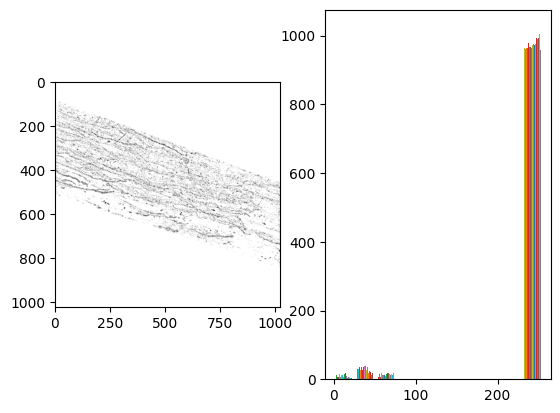

In [25]:
clahe = cv.createCLAHE(clipLimit=25.0, tileGridSize=(100,100))
cl1 = clahe.apply(cropped_image)
cl1 = 255 - cl1
cl1[cl1 >60 ] =255
f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(cl1, cmap = 'gray')
axarr[1].hist(cl1)

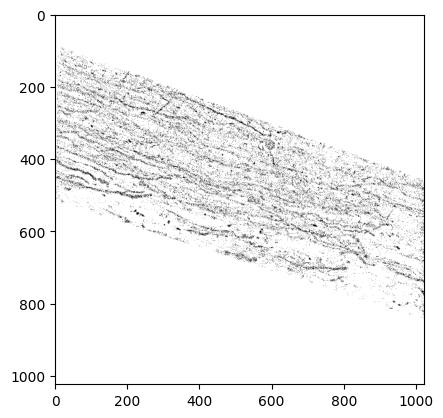

In [26]:
ret, thresh = cv.threshold(cl1, 0,255,cv.THRESH_BINARY + cv.THRESH_OTSU)
kernel = np.ones((1,1),np.float32)/1
thresh = cv.erode(thresh, kernel, iterations=3)
#print(thresh

plt.imshow(thresh, cmap = 'gray')

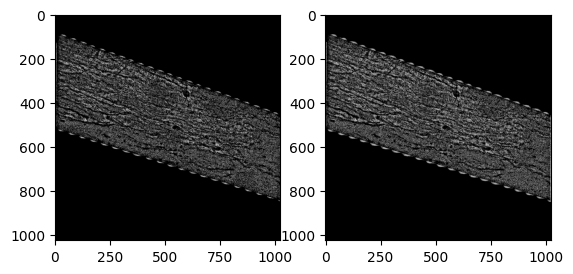

In [27]:
kernel3 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
kernel5 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
kernel7 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(7,7))
t_lo = 150
t_hi = 160


clahe = cv.createCLAHE(clipLimit=128.0, tileGridSize=(64, 64))
cl1 = clahe.apply(cropped_image)
cl1 = 255 - cl1

ret, thresh_hi = cv.threshold(cl1, t_hi, 255, cv.THRESH_TOZERO)
rt, thresh_lo = cv.threshold(cl1, t_lo, 255, cv.THRESH_TOZERO)

f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(thresh_hi, cmap = 'gray')
axarr[1].imshow(thresh_lo, cmap = 'gray')

In [22]:
# preparations and clean up
np.ones((3, 3), np.uint8) 

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

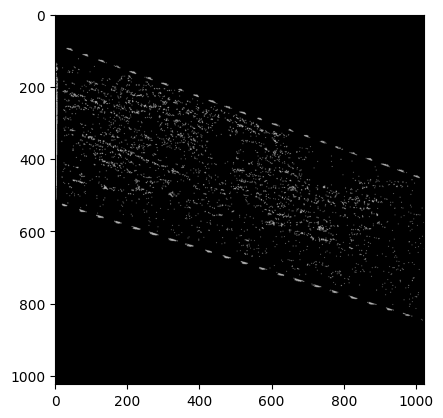

In [23]:
current = np.copy(thresh_hi)
prev = np.copy(current)
prev[:] = 0
current = cv.morphologyEx(current, cv.MORPH_OPEN, np.ones((2, 2), np.uint8) )
iter_num = 0
max_iter = 1000
plt.imshow(current, cmap = 'gray')

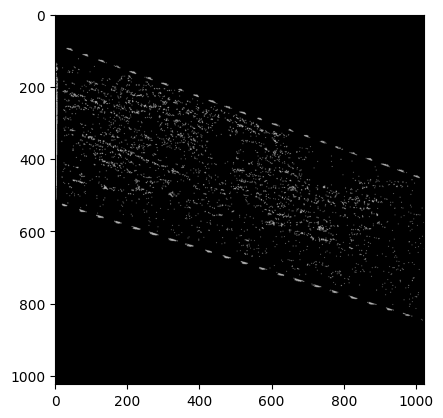

In [91]:
while np.sum(current - prev) > 0 and iter_num < max_iter:
    iter_num = iter_num+1
    prev = np.copy(current)
    current = cv.dilate(current, kernel3)
    current[np.where(thresh_lo == 0)] = 0
plt.imshow(current, cmap = 'gray')

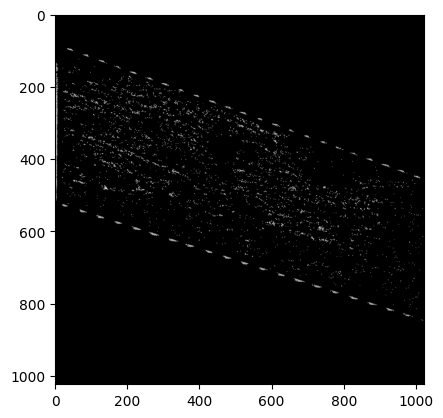

In [94]:
opening = cv.morphologyEx(current, cv.MORPH_OPEN, np.ones((2, 2), np.uint8))   
cl1[np.where(opening == 0)] = 0

plt.imshow(cl1, cmap = 'gray')

### Try 2
https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html

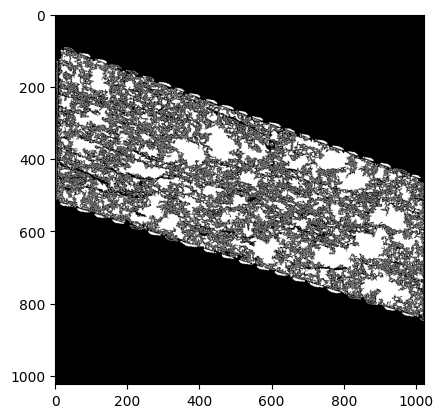

In [98]:
from skimage import feature

edges =  feature.canny(thresh_hi / 255.)
import scipy as sp
fill_axon = sp.ndimage.binary_fill_holes(edges)
plt.imshow(fill_axon, cmap = 'gray')

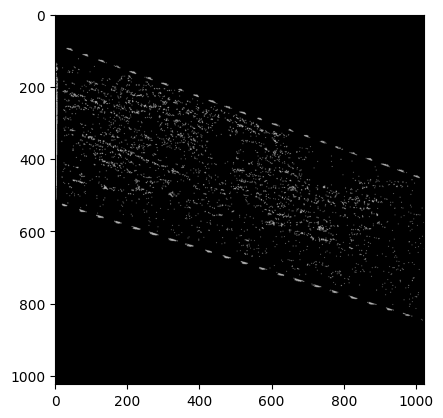

In [99]:
plt.imshow(current, cmap = 'gray')

In [102]:
fill_axon

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

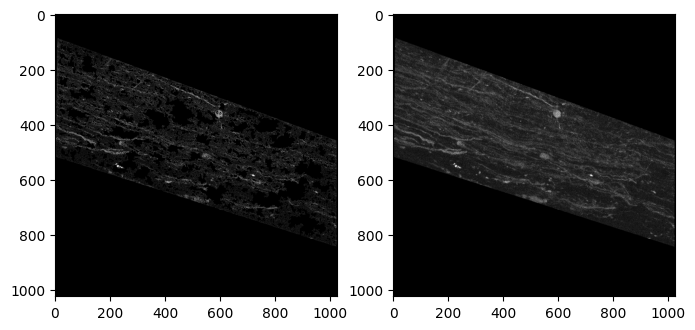

In [107]:
try_image = np.copy(cropped_image)
for x in x_values:
    for y in y_values:
        if fill_axon[x][y] == True:
            try_image[x][y] = 0
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(try_image, cmap = 'gray')
ax[1].imshow(cropped_image, cmap = 'gray')

plt.show()

### Histogram Equalization

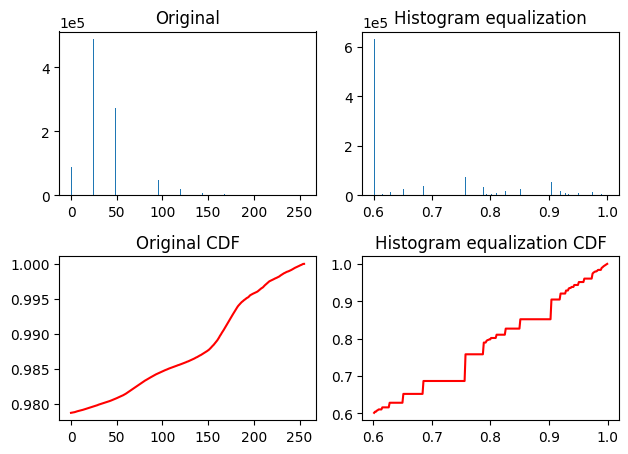

In [108]:
equalized = exposure.equalize_hist(cropped_image)

fig, ((a, b), (c, d)) = plt.subplots(nrows=2, ncols=2)

plot_hist(a, integrated_image, title="Original")
plot_hist(b, equalized, title="Histogram equalization")

cdf, bins = exposure.cumulative_distribution(cl1.ravel())
c.plot(bins, cdf, "r")
c.set_title("Original CDF")

cdf, bins = exposure.cumulative_distribution(equalized.ravel())
d.plot(bins, cdf, "r")
d.set_title("Histogram equalization CDF");

fig.tight_layout()

#viewer.add_image(equalized, contrast_limits=[0, 1], name='histeq')

(array([  9388.,   7544.,  10509.,  13975.,   9628.,      0.,   8291.,
          8451.,  15600.,  16780.,      0.,  55422.,      0.,      0.,
             0.,      0.,      0.,      0.,  26294.,      0.,      0.,
         17133.,      0.,   9197.,   3974.,   8869.,  32974.,      0.,
             0.,      0.,  74990.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,  36264.,      0.,      0.,
             0.,  24865.,      0.,      0.,  12982.,      0.,   7842.,
        637604.]),
 array([0.        , 0.00798164, 0.01596329, 0.02394493, 0.03192657,
        0.03990822, 0.04788986, 0.05587151, 0.06385315, 0.07183479,
        0.07981644, 0.08779808, 0.09577972, 0.10376137, 0.11174301,
        0.11972466, 0.1277063 , 0.13568794, 0.14366959, 0.15165123,
        0.15963287, 0.16761452, 0.17559616, 0.1835778 , 0.19155945,
        0.19954109, 0.20752274, 0.21550438, 0.22348602, 0.23146767,
        0.23944931, 0.24743095, 0.2554126 , 0.26339424, 0.27137589,
        

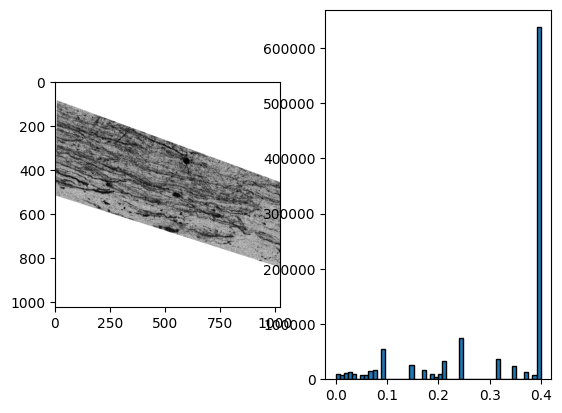

In [109]:
equalized = (1 - equalized)

f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(equalized, cmap = 'gray')
axarr[1].hist( equalized.flatten(), bins=50, edgecolor='black')



(array([  6845.,  10087.,   2670.,   7839.,  13975.,      0.,   9628.,
             0.,   8291.,   5491.,   4563.,  13997.,      0.,  16780.,
             0.,  55422.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,  26294.,      0.,      0.,      0.,
         17133.,      0.,      0.,   9197.,      0.,   5713.,   7130.,
         32974.,      0.,      0.,      0.,      0.,  74990.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
        719557.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

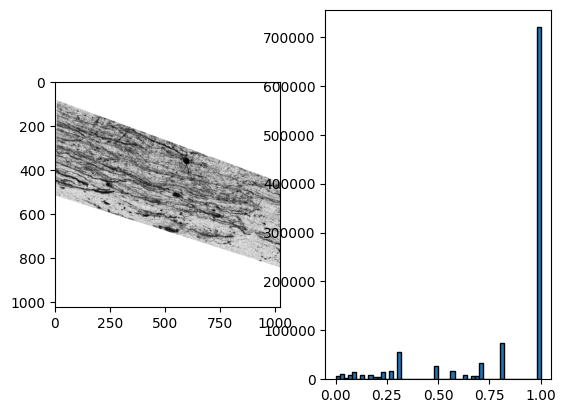

In [111]:
img_contrast = exposure.rescale_intensity(equalized, in_range=(0, 0.3))
f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img_contrast, cmap = 'gray')

axarr[1].hist(img_contrast.flatten(), bins=50, edgecolor='black')

(array([  6845.,  10087.,   2670.,   7839.,  13975.,      0.,   9628.,
             0.,   8291.,   5491.,   4563.,  13997.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
        965190.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

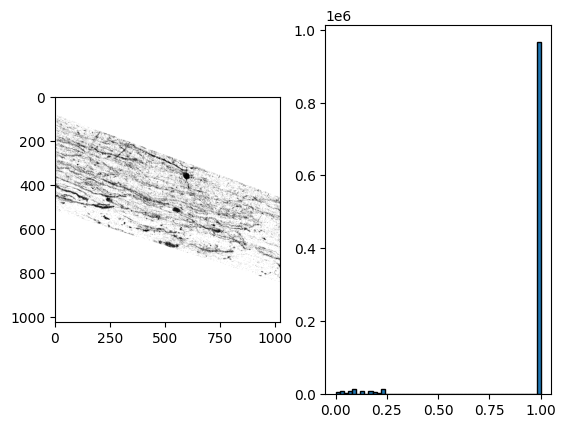

In [112]:
img_contrast[img_contrast > 0.25] = 1
f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img_contrast, cmap = 'gray')

axarr[1].hist(img_contrast.flatten(), bins=50, edgecolor='black')

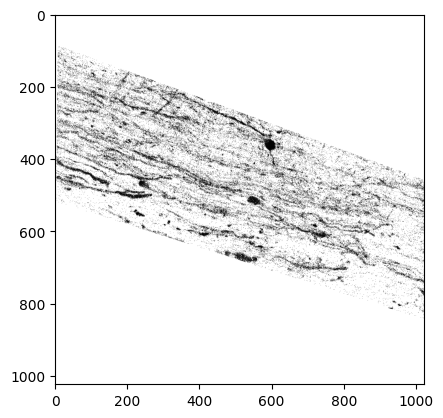

In [113]:
plt.imshow(img_contrast, cmap = 'gray')

(array([1.8810e+03, 1.5270e+03, 1.5550e+03, 1.8820e+03, 1.0230e+03,
        3.3060e+03, 0.0000e+00, 5.7580e+03, 0.0000e+00, 0.0000e+00,
        2.6700e+03, 0.0000e+00, 1.6850e+03, 8.7600e+02, 2.3790e+03,
        2.8990e+03, 0.0000e+00, 1.3975e+04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 9.6280e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 8.2910e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.4910e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.9600e+03, 0.0000e+00, 1.6030e+03, 5.4570e+03,
        0.0000e+00, 0.0000e+00, 8.5400e+03, 0.0000e+00, 9.6519e+05]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

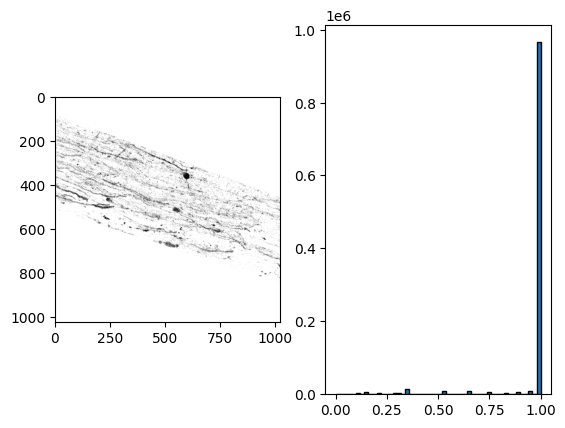

In [117]:
try_1 = exposure.rescale_intensity(img_contrast, in_range=(0, 0.25))
f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(try_1, cmap = 'gray')

axarr[1].hist(try_1.flatten(), bins=50, edgecolor='black')

(array([1.52000e+03, 1.78600e+03, 5.75800e+03, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.67000e+03, 0.00000e+00, 1.68500e+03, 8.76000e+02,
        2.37900e+03, 2.89900e+03, 0.00000e+00, 1.39750e+04, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 9.62800e+03, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        8.29100e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 5.49100e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.96000e+03, 0.00000e+00, 1.17900e+03, 5.88100e+03, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 8.54000e+03, 0.00000e+00, 9.73058e+05]),
 array([0.10004679, 0.11804586, 0.13604492, 0.15404399, 0.17204305,
        0.19004211, 0.20804118, 0.22604024, 0.24403931, 0.26203837,
        0.28003743, 0.2980365 , 0.31603556, 0.33403463, 0.35203369,
        0.37003276, 0.38803182, 0.40603088, 0.42402995, 0.442029

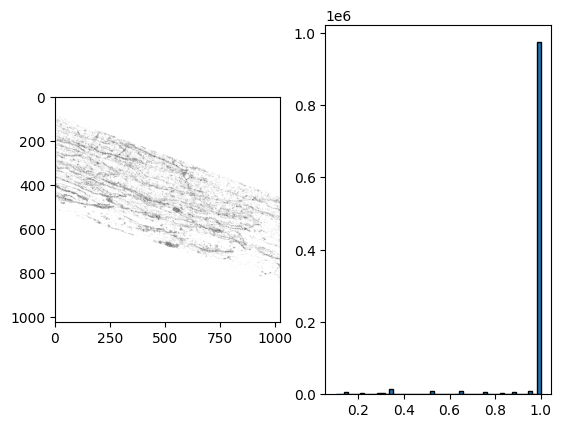

In [118]:
try_1[try_1 < 0.1] = 1
f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(try_1, cmap = 'gray')

axarr[1].hist(try_1.flatten(), bins=50, edgecolor='black')

(array([1.429500e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 3.690000e+02, 1.350000e+02, 6.720000e+02,
        0.000000e+00, 1.033105e+06]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.

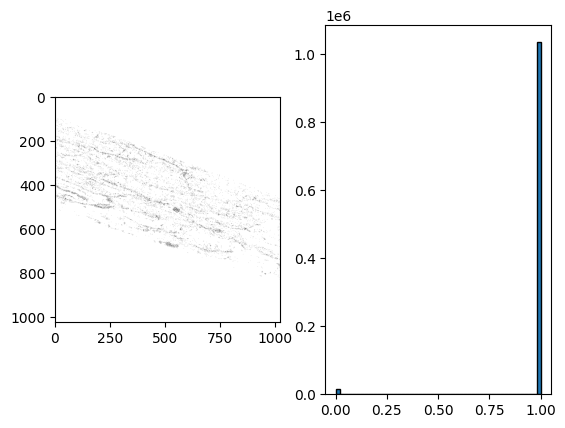

In [119]:
try_2 = exposure.rescale_intensity(try_1, in_range=(0.1, 0.3))
try_2[try_2 < 0.9] = 0

f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(try_2, cmap = 'gray')

axarr[1].hist(try_2.flatten(), bins=50, edgecolor='black')

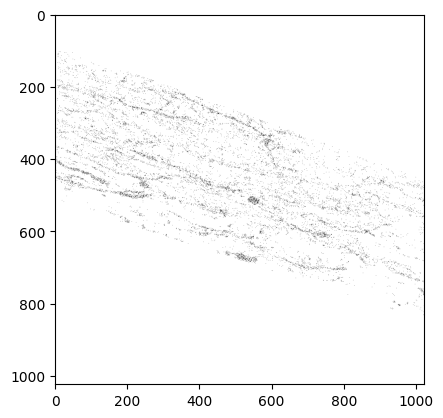

In [123]:
plt.imshow(try_2, cmap = 'gray')


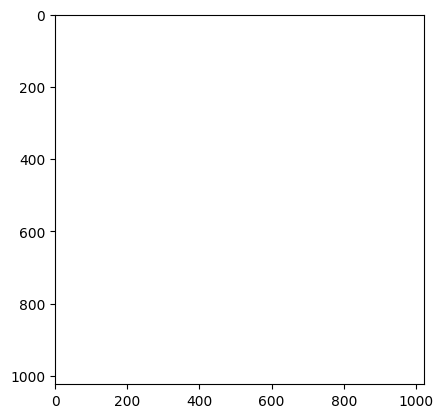

In [122]:
invert = cv.bitwise_not(try_2) 
dilation = cv.dilate(invert, np.ones((0, 1), np.uint8) , iterations=1) 
  
# print the output 
plt.imshow(dilation, cmap='gray') 

C:\Users\Ding-Yang\anaconda3\envs\intern\Lib\site-packages\skimage\filters\thresholding.py:757: RuntimeWarning: divide by zero encountered in log
  / (np.log(mean_back) - np.log(mean_fore)))


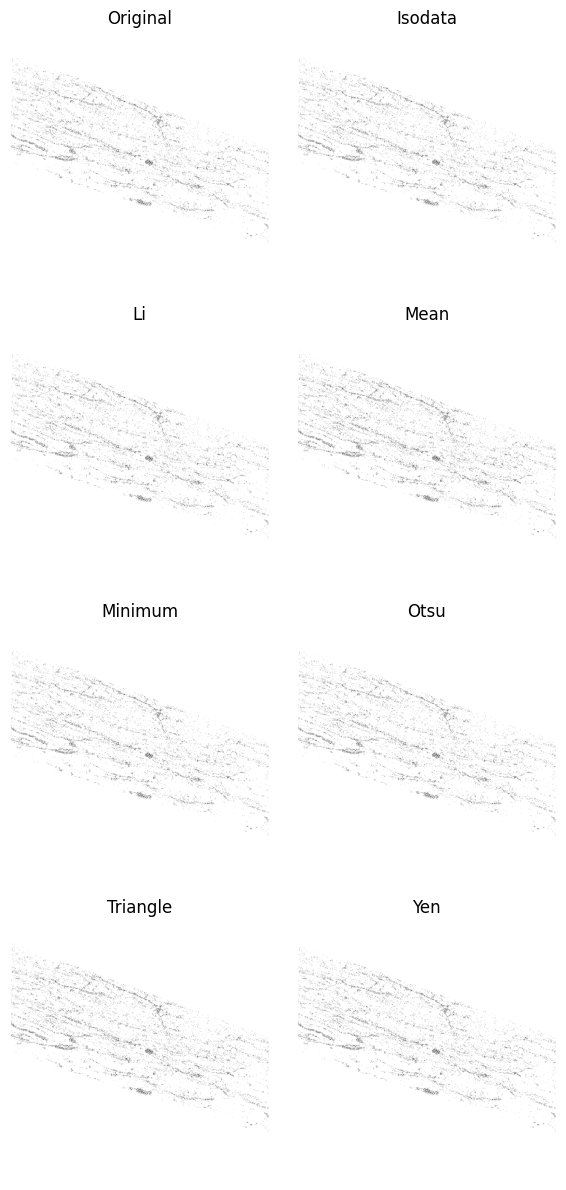

In [124]:
dilation[np.isnan(dilation)] = 0
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(try_2, figsize=(6, 12), verbose=False)
plt.show()
#Isodata, Li, Mean, triangle, Yen have good performance for the images[1]

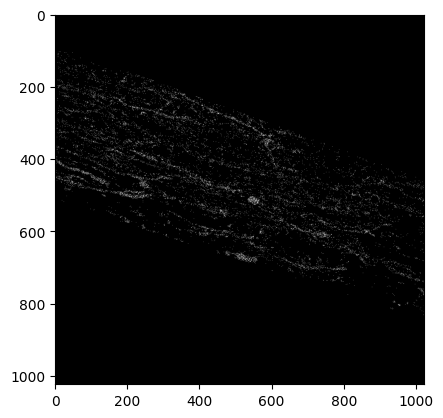

In [126]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(try_2)
otsu_thresholded_image = try_2 > threshold
otsu_thresholded_image
opening[np.where(otsu_thresholded_image < 1)] = 0
opening = 1-opening
plt.imshow(opening, cmap='gray')

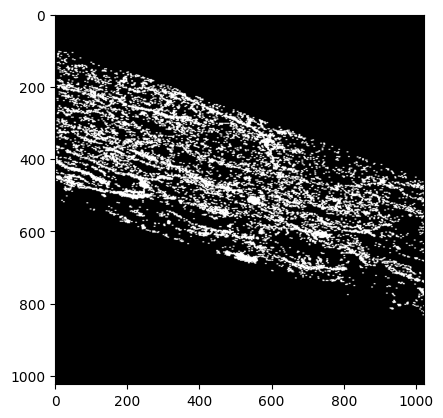

In [128]:
# invert = cv2.bitwise_not(opening) 
dilation = cv.dilate(opening, np.ones((3, 5), np.uint8) , iterations=1) 
  
# print the output 
plt.imshow(dilation, cmap='gray') 

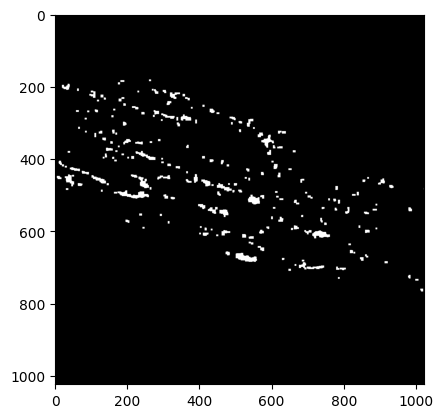

In [130]:
se1 = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
se2 = cv.getStructuringElement(cv.MORPH_RECT, (2,2))

closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, se1)
opening_2 = cv.morphologyEx(closing, cv.MORPH_OPEN, se1)

#f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
#axarr[0].imshow(closing, cmap = 'gray')

#axarr[1].imshow(opening_2, cmap = 'gray')
plt.imshow(opening_2, cmap = 'gray')

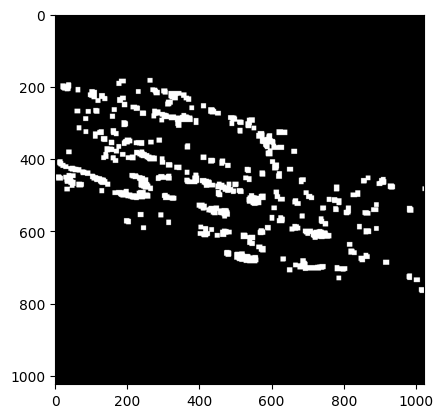

In [132]:
try_5 = cv.dilate(opening_2, np.ones((9, 9), np.uint8) , iterations=1) 
plt.imshow(try_5, cmap = 'gray')

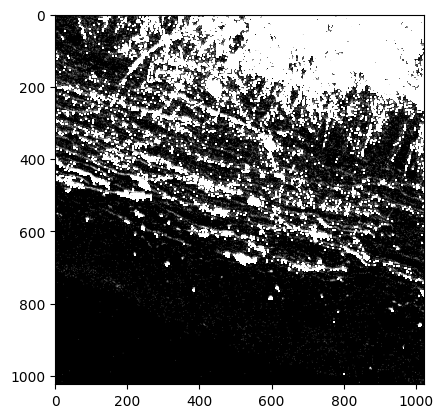

In [255]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(integrated_image)
otsu_thresholded_image = integrated_image > threshold
otsu_thresholded_image
opening[np.where(otsu_thresholded_image < 1)] = 0
opening = 1-opening
plt.imshow(opening, cmap='gray')

In [301]:
# Capture the mouse click events in Python and OpenCV
'''
-> draw shape on any image 
-> reset shape on selection
-> crop the selection
run the code : python capture_events.py --image image_example.jpg
'''


# import the necessary packages
import argparse
import cv2

# initialize the list of reference points and boolean indicating
# whether cropping is being performed or not
ref_point = []
cropping = False

def shape_selection(event, x, y, flags, param):
  # grab references to the global variables
  global ref_point, cropping

  # if the left mouse button was clicked, record the starting
  # (x, y) coordinates and indicate that cropping is being
  # performed
  if event == cv2.EVENT_LBUTTONDOWN:
    ref_point = [(x, y)]
    cropping = True

  # check to see if the left mouse button was released
  elif event == cv2.EVENT_LBUTTONUP:
    # record the ending (x, y) coordinates and indicate that
    # the cropping operation is finished
    ref_point.append((x, y))
    cropping = False

    # draw a rectangle around the region of interest
    cv2.rectangle(image, ref_point[0], ref_point[1], (0, 255, 0), 2)
    cv2.imshow("image", image)


# load the image, clone it, and setup the mouse callback function
image = np.copy(otsu_thresholded_image)
clone = image.copy()
cv2.namedWindow("image")
cv2.setMouseCallback("image", shape_selection)

# keep looping until the 'q' key is pressed
while True:
  # display the image and wait for a keypress
  cv2.imshow(image)
  key = cv2.waitKey(1) & 0xFF

  # if the 'r' key is pressed, reset the cropping region
  if key == ord("r"):
    image = clone.copy()

  # if the 'c' key is pressed, break from the loop
  elif key == ord("c"):
    break

# if there are two reference points, then crop the region of interest
# from teh image and display it
if len(ref_point) == 2:
  crop_img = clone[ref_point[0][1]:ref_point[1][1], ref_point[0][0]:ref_point[1][0]]
  cv2.imshow("crop_img", crop_img)
  cv2.waitKey(0)

# close all open windows
cv2.destroyAllWindows()


error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


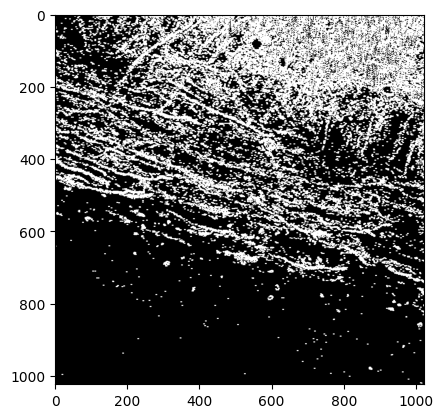

In [304]:
plt.imshow(otsu_thresholded_image, cmap='gray')
plt.imsave( 'try.jpg',otsu_thresholded_image)

### Try all threshold

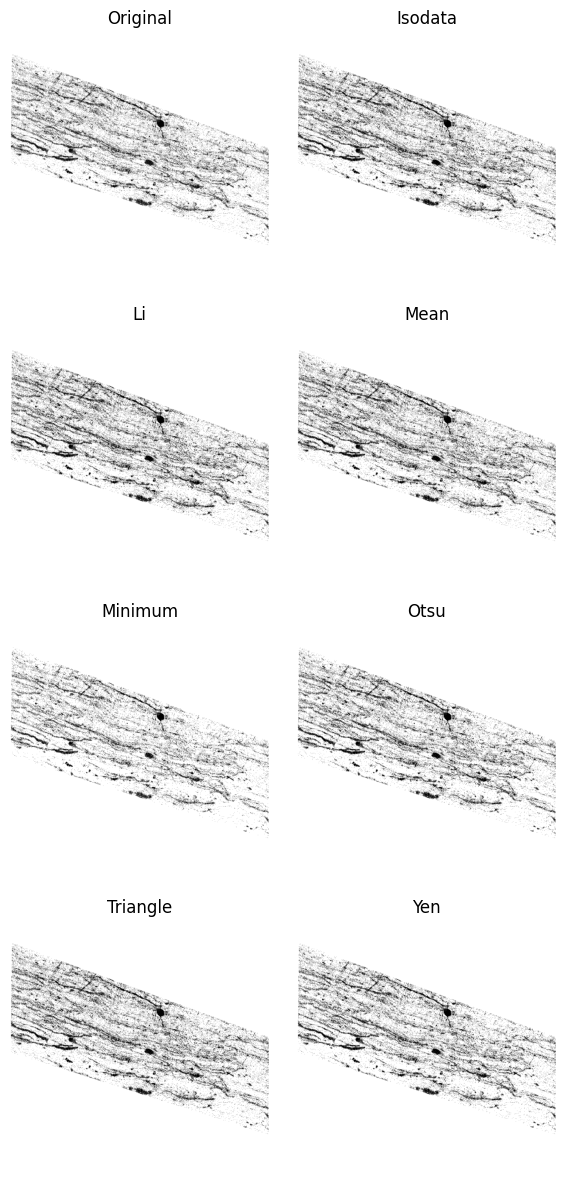

In [116]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(img_contrast, figsize=(6, 12), verbose=False)
plt.show()
#Isodata, Li, Mean, triangle, Yen have good performance for the images[1]

### Try to make alogrithm

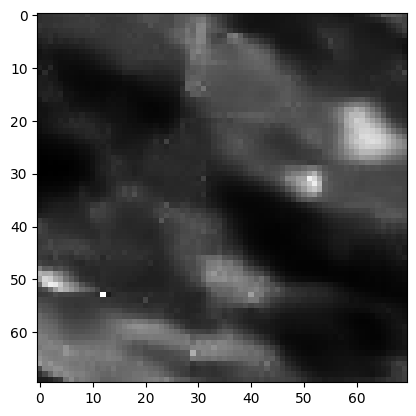

In [88]:
plt.imshow(denoised_image[280:350,130:200], cmap = 'gray')

In [120]:
denoised_image[416:422,80:86]

array([[43.26917267, 44.70193481, 43.46327972, 49.01886368, 54.11936569,
        53.37442017],
       [37.38982391, 37.576828  , 39.2141304 , 41.61733627, 49.79542923,
        57.80293655],
       [31.42743492, 31.95043755, 32.51797104, 34.70903778, 37.20034027,
        52.24298096],
       [29.73387909, 30.02990341, 30.60517693, 32.18037415, 33.39613724,
        41.99520874],
       [29.10152245, 29.03405571, 29.02762032, 29.17921829, 28.89283752,
        29.71894836],
       [29.15001869, 29.05485916, 28.86893845, 28.81443596, 28.72636604,
        27.23752403]])

In [95]:
try_1 = np.sort(denoised_image[412:418,80:86].flatten())[::-1]
try_2 = np.sort(denoised_image[416:422,86:92].flatten())[::-1]
try_3 =  np.sort(denoised_image[416:422,80:86].flatten())[::-1]
np.linalg.norm(try_1-try_3) / (6**2) #distance.euclidea


0.6880796243285909

In [125]:
np.mean(denoised_image[412:418,80:86])

denoised_image[412:418,80:86]


array([0., 0., 0., ..., 0., 0., 0.])

In [122]:
from scipy.stats import shapiro 
from scipy.stats import lognorm

#perform Shapiro-Wilk test for normality
shapiro(denoised_image[412:418,80:86]).pvalue

0.06885512918233871

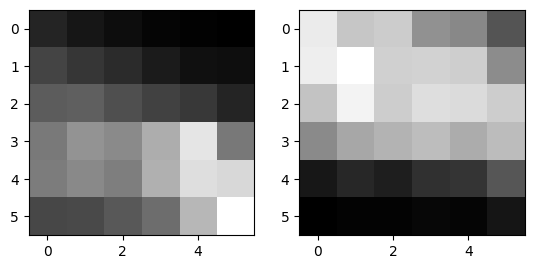

In [112]:
f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow( denoised_image[412:418,80:86], cmap = 'gray')

axarr[1].imshow( denoised_image[416:422,86:92], cmap = 'gray')

In [132]:
denoised_image[412:418,80:86]

array([[33.57722092, 31.98410225, 30.93718719, 30.04540443, 29.77635574,
        29.45487976],
       [37.08766937, 35.4601059 , 34.26579285, 32.53479767, 31.32746887,
        31.09740639],
       [39.6655159 , 40.01305389, 38.22367096, 36.81538391, 35.83964539,
        33.48044968],
       [43.04871368, 45.94855499, 44.82332993, 48.64130402, 54.85009766,
        42.75210953],
       [43.26917267, 44.70193481, 43.46327972, 49.01886368, 54.11936569,
        53.37442017],
       [37.38982391, 37.576828  , 39.2141304 , 41.61733627, 49.79542923,
        57.80293655]])

In [133]:
denoised_image[416:422,86:92]

array([[53.44774628, 49.41518784, 50.12498093, 43.73706055, 42.71585083,
        37.1896286 ],
       [53.77383804, 55.61722183, 50.51276016, 50.74646759, 50.24399948,
        43.17923355],
       [49.22774124, 54.3037529 , 50.19753265, 52.05911255, 51.71670532,
        50.16701508],
       [42.96353531, 46.11215591, 47.53697968, 48.44583511, 46.65536499,
        48.34256744],
       [30.6146698 , 32.28148651, 31.29943848, 33.22990799, 33.77863693,
        37.32577515],
       [28.05777359, 28.48758698, 28.40616035, 28.81379128, 28.70316887,
        30.39857483]])

True

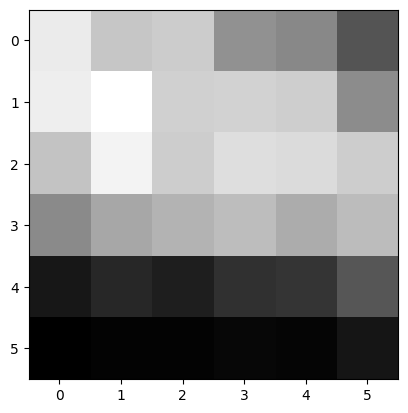

In [99]:
plt.imshow( denoised_image[416:422,86:92], cmap = 'gray')

True

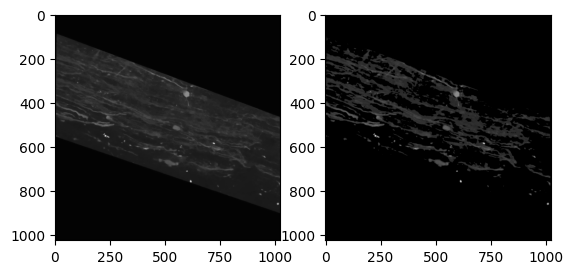

In [109]:
try1 = np.copy(denoised_image)
try1[try1<41.6] = 0
f, axarr = plt.subplots(nrows=1, ncols=2) 

axarr[0].imshow( denoised_image, cmap = 'gray')

axarr[1].imshow( try1, cmap = 'gray')
try1[416:422,80:86]
cv.imwrite( "try1.jpg",try1)

### Try denosie and hitogram equlization and all threshold

In [146]:
import bm3d

denoised_image = bm3d.bm3d(cropped_image, sigma_psd=25, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
cv.imwrite( "denoised.jpg",denoised_image)
Gau = cv2.GaussianBlur(cropped_image, (7,7), 3) #去除雜質
cv.imwrite( "gau_denoised.jpg",Gau)

True

In [147]:
 # Call the capture_partial_image.py script with the image path
script_path = "./BM3D.py"  # Replace with the actual path
subprocess.run(["python", script_path], check=True)

CompletedProcess(args=['python', './BM3D.py'], returncode=0)

Bin 1: Range 1.00 to 25.30, Count: 82288.0
Bin 2: Range 25.30 to 49.60, Count: 340192.0
Bin 3: Range 49.60 to 73.90, Count: 59749.0
Bin 4: Range 73.90 to 98.20, Count: 7151.0
Bin 5: Range 98.20 to 122.50, Count: 1335.0
Bin 6: Range 122.50 to 146.80, Count: 531.0
Bin 7: Range 146.80 to 171.10, Count: 145.0
Bin 8: Range 171.10 to 195.40, Count: 51.0
Bin 9: Range 195.40 to 219.70, Count: 24.0
Bin 10: Range 219.70 to 244.00, Count: 28.0


<BarContainer object of 10 artists>

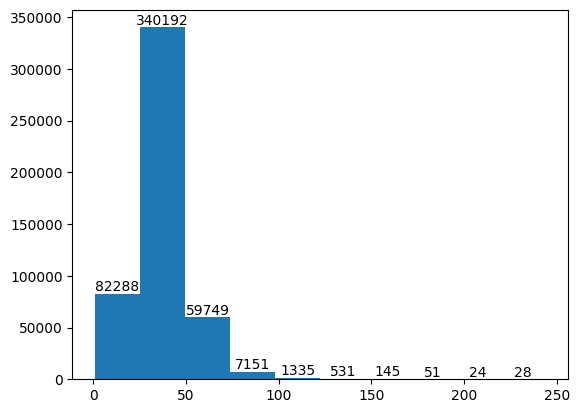

In [3]:
 
try1 = cv.imread("./Basic3.jpg")
try1 = cv.cvtColor(try1, cv.COLOR_BGR2GRAY)
#f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
#axarr[0].imshow(try1, cmap = 'gray')

counts, edges, bars = plt.hist(try1[try1 != 0])
plt.bar_label(bars)

for i in range(len(counts)):
    print(f"Bin {i + 1}: Range {edges[i]:.2f} to {edges[i + 1]:.2f}, Count: {counts[i]}")
bars

Highest Count: 340192.0, Bin with Highest Count: 2, Range of the Bin: 25.30 to 49.60


49.6

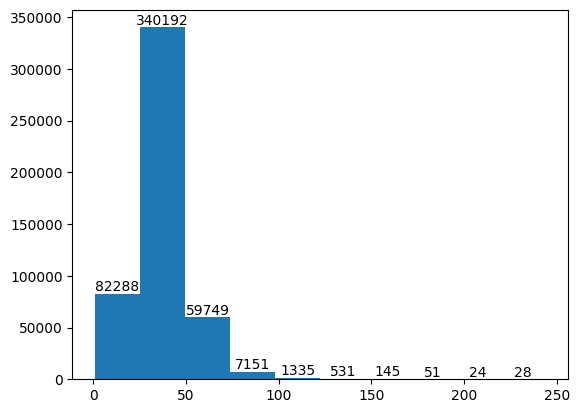

In [15]:
counts, edges, bars = plt.hist(try1[try1 != 0])
plt.bar_label(bars)

# Find the index of the maximum count
max_count_index = np.argmax(counts)

# Print the information about the bin with the highest count
print(f"Highest Count: {counts[max_count_index]}" + f", Bin with Highest Count: {max_count_index + 1}"+ f", Range of the Bin: {edges[max_count_index]:.2f} to {edges[max_count_index + 1]:.2f}")
edges[max_count_index + 1]

Bin 1: Range 26.00 to 28.30, Count: 55447.0
Bin 2: Range 28.30 to 30.60, Count: 28398.0
Bin 3: Range 30.60 to 32.90, Count: 30945.0
Bin 4: Range 32.90 to 35.20, Count: 50672.0
Bin 5: Range 35.20 to 37.50, Count: 33320.0
Bin 6: Range 37.50 to 39.80, Count: 30317.0
Bin 7: Range 39.80 to 42.10, Count: 39360.0
Bin 8: Range 42.10 to 44.40, Count: 23044.0
Bin 9: Range 44.40 to 46.70, Count: 22370.0
Bin 10: Range 46.70 to 49.00, Count: 26319.0


<BarContainer object of 10 artists>

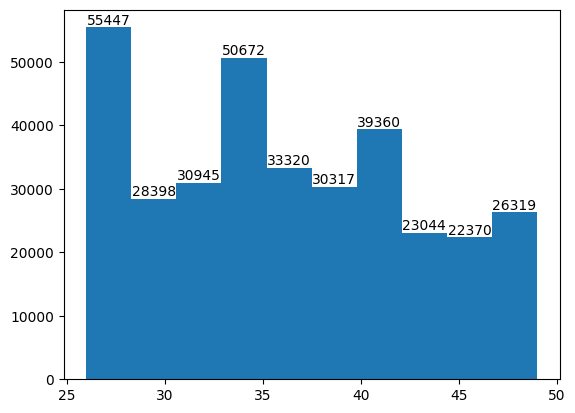

In [6]:
counts, edges, bars = plt.hist(try1[(try1 > 25) & (try1 < 50)])
plt.bar_label(bars)

for i in range(len(counts)):
    print(f"Bin {i + 1}: Range {edges[i]:.2f} to {edges[i + 1]:.2f}, Count: {counts[i]}")
bars

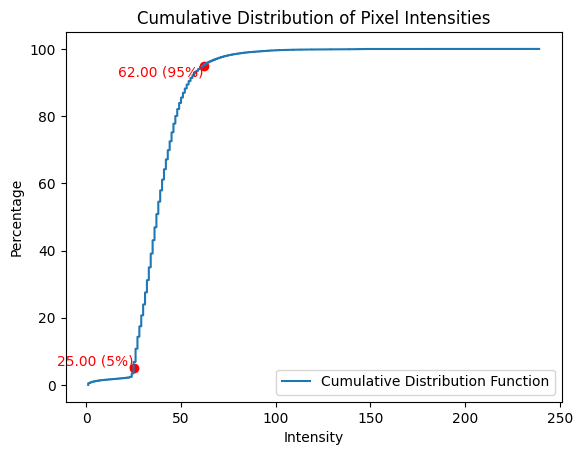

In [84]:
non_zero_pixels = try1[try1 > 0]
# Calculate the cumulative distribution function (CDF)
sorted_pixels = np.sort(non_zero_pixels)
cumulative_percentage = np.arange(1, len(sorted_pixels) + 1) / len(sorted_pixels) * 100

# Plot the CDF
plt.plot(sorted_pixels, cumulative_percentage, label='Cumulative Distribution Function')

# Calculate intensity values for 5% and 95%
intensity_005 = np.percentile(sorted_pixels, 5)
intensity_095 = np.percentile(sorted_pixels, 95)

# Label points on the plot
plt.scatter([intensity_005, intensity_095], [5, 95], color='red')
plt.text(intensity_005, 5, f'{intensity_005:.2f} (5%)', verticalalignment='bottom', horizontalalignment='right', color='red')
plt.text(intensity_095, 95, f'{intensity_095:.2f} (95%)', verticalalignment='top', horizontalalignment='right', color='red')

# Add labels and title
plt.xlabel('Intensity')
plt.ylabel('Percentage')
plt.title('Cumulative Distribution of Pixel Intensities')
plt.legend()

plt.show()

In [ ]:
edges = cv2.Canny(try1, 50, 150, apertureSize=3)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
for line in lines:
    x1, y1, x2, y2 = line[0]  # 这里直接返回的是坐标，不用变换
    cv2.line(try1, (x1, y1), (x2, y2), (0, 255,0), 2)
plt.imshow('houghlinep', try1)



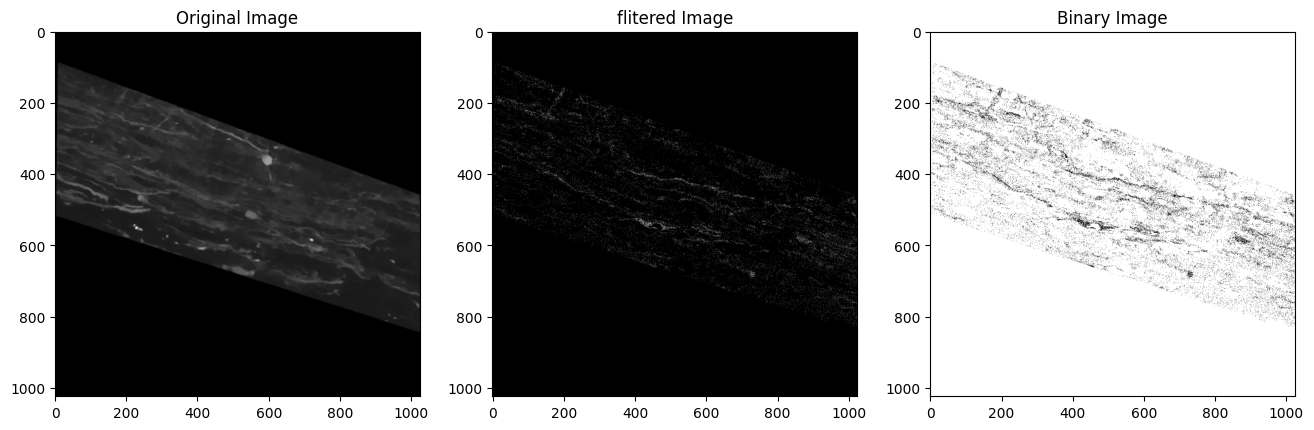

In [98]:
lower_threshold = intensity_005
upper_threshold = intensity_095


binary_mask = cv2.inRange(try1, lower_threshold, upper_threshold)

# Apply the mask to the original image
result = cv2.bitwise_and(try1, img, mask=binary_mask)
binary_image = 255 - result
binary_image[binary_image < 255 ]=0


# Display the original and binary images
plt.figure(figsize=(16, 16))
plt.subplot(1, 3, 1), plt.imshow(try1, cmap='gray'), plt.title('Original Image')
plt.subplot(1, 3, 2), plt.imshow(result, cmap='gray'), plt.title('flitered Image')
plt.subplot(1, 3, 3), plt.imshow(binary_image, cmap='gray'), plt.title('Binary Image')

plt.show()

In [ ]:
upper_threshold = intensity_095


binary_mask = cv2.inRange(try1, upper_threshold, 255)

# Apply the mask to the original image
result = cv2.bitwise_and(try1, img, mask=binary_mask)
binary_image = try1
binary_image[binary_image < upper_threshold ]=0
binary_image = 255 - binary_image


# Display the original and binary images
plt.figure(figsize=(16, 16))
plt.subplot(1, 3, 1), plt.imshow(try1, cmap='gray'), plt.title('Original Image')
plt.subplot(1, 3, 2), plt.imshow(result, cmap='gray'), plt.title('flitered Image')
plt.subplot(1, 3, 3), plt.imshow(binary_image, cmap='gray'), plt.title('Binary Image')

plt.show()

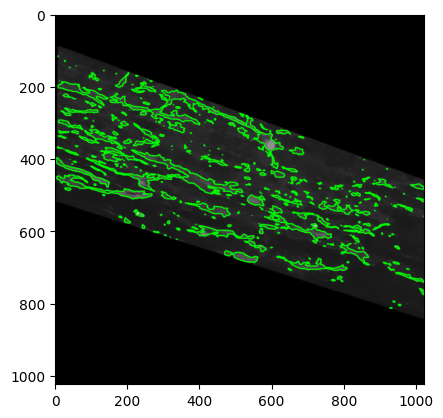

In [131]:
import cv2

# Load your image
_src = cv2.imread('Basic3.jpg', cv2.IMREAD_COLOR)

# Convert to grayscale if needed
gray_image = cv2.cvtColor(_src, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary image
ret, binary_img = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)

# Find contours
contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                       
# draw contours on the original image
image_copy = _src.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
                
# see the results
plt.imshow( image_copy)

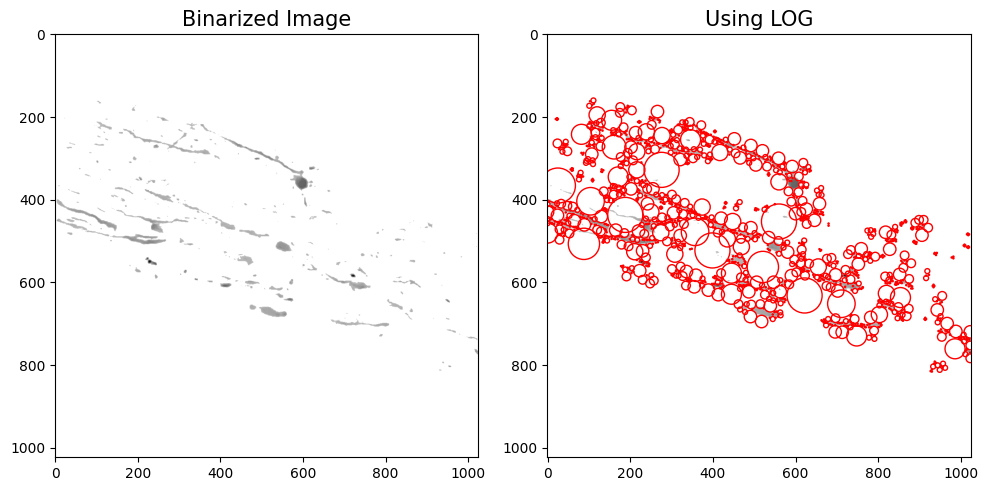

In [127]:
from skimage.feature import blob_dog, blob_log, blob_doh

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('Binarized Image',fontsize=15)
ax[0].imshow(binary_image,cmap='gray')
blobs = blob_log(binary_image, max_sigma=30, threshold=0.01)
ax[1].imshow(binary_image, cmap='gray')
for blob in blobs:
    y, x, area = blob
    ax[1].add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                            fill=False))
ax[1].set_title('Using LOG',fontsize=15)
plt.tight_layout()
plt.show()

#### Skeletonize
https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html#sphx-glr-auto-examples-edges-plot-skeleton-py

Measure region properties
https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html#sphx-glr-auto-examples-segmentation-plot-regionprops-py

(array([[   0.,    0.,    0., ...,    0.,    0., 1024.],
        [   0.,    0.,    0., ...,    0.,    0., 1024.],
        [   0.,    0.,    0., ...,    0.,    0., 1024.],
        ...,
        [   0.,    0.,    0., ...,   58.,  241.,  663.],
        [   0.,    0.,    0., ...,   51.,  254.,  668.],
        [   0.,    0.,    0., ...,   46.,  264.,  671.]]),
 array([ 20. ,  43.5,  67. ,  90.5, 114. , 137.5, 161. , 184.5, 208. ,
        231.5, 255. ]),
 <a list of 1024 BarContainer objects>)

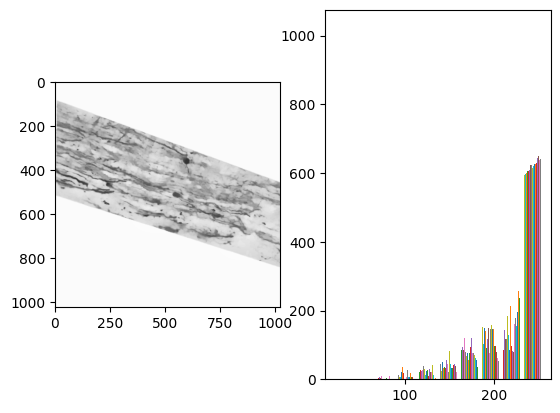

In [39]:
import cv2

# Load your image
_src = cv2.imread('Basic3.jpg', cv2.IMREAD_COLOR)

# Convert to grayscale if needed
gray_image = cv2.cvtColor(_src, cv2.COLOR_BGR2GRAY)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_output= clahe.apply(gray_image)
clahe_output = 255 - clahe_output
clahe_output[clahe_output <20 ] =255
# Display the result or save it
f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(clahe_output, cmap = 'gray')
axarr[1].hist(clahe_output)

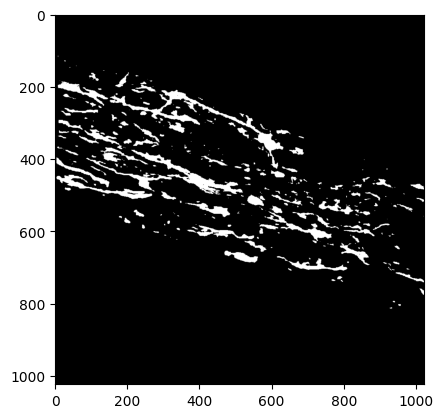

In [30]:
# apply binary thresholding
ret, thresh = cv.threshold(try1, 50, 255, cv2.THRESH_BINARY)
# visualize the binary image
plt.imshow( thresh)

#### draw contours
https://learnopencv.com/contour-detection-using-opencv-python-c/

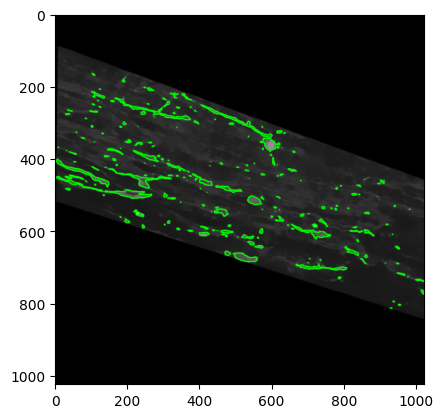

In [113]:
import cv2

# Load your image
_src = cv2.imread('Basic3.jpg', cv2.IMREAD_COLOR)

# Convert to grayscale if needed
gray_image = cv2.cvtColor(_src, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary image
ret, binary_img = cv2.threshold(gray_image, upper_threshold, 255, cv2.THRESH_BINARY)

# Find contours
contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                       
# draw contours on the original image
image_copy = _src.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
                
# see the results
plt.imshow( image_copy)

In [37]:
    '''
    *快速匹配算法,返回邻域内寻找和当前_block相似度最高的几个block,要同时返回basicImg和IMG
    *_Basic_img: 基础去噪之后的图像
    *_noisyImg:噪声图像
    *_BlockPoint:当前block的坐标及大小
    '''

Second_Match_threshold = 400           # 用于计算block之间相似度的阈值
Step2_max_matched_cnt = 32
Step2_Blk_Size = 3
Step2_Blk_Step = 2
Step2_Search_Step = 3
Step2_Search_Window = 39


    (present_x, present_y) = _BlockPoint  # 当前坐标
    Blk_Size = Step2_Blk_Size
    Threshold = Second_Match_threshold
    Search_Step = Step2_Search_Step
    max_matched = Step2_max_matched_cnt
    Window_size = Step2_Search_Window

    blk_positions = numpy.zeros((max_matched, 2), dtype=int)  # 用于记录相似blk的位置
    Final_similar_blocks = numpy.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)
    Final_noisy_blocks = numpy.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)

    img = _Basic_img[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
    dct_img = cv2.dct(img.astype(numpy.float32))  # 对目标作block作二维余弦变换
    Final_similar_blocks[0, :, :] = dct_img

    n_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
    dct_n_img = cv2.dct(n_img.astype(numpy.float32))  # 对目标作block作二维余弦变换
    Final_noisy_blocks[0, :, :] = dct_n_img

    blk_positions[0, :] = _BlockPoint

    Window_location = Define_SearchWindow(_noisyImg, _BlockPoint, Window_size, Blk_Size)
    blk_num = (Window_size-Blk_Size)/Search_Step  # 确定最多可以找到多少相似blk
    blk_num = int(blk_num)
    (present_x, present_y) = Window_location

    similar_blocks = numpy.zeros((blk_num**2, Blk_Size, Blk_Size), dtype=float)
    m_Blkpositions = numpy.zeros((blk_num**2, 2), dtype=int)
    Distances = numpy.zeros(blk_num**2, dtype=float)  # 记录各个blk与它的相似度

    # 开始在_Search_Window中搜索,初始版本先采用遍历搜索策略,这里返回最相似的几块
    matched_cnt = 0
    for i in range(blk_num):
        for j in range(blk_num):
            tem_img = _Basic_img[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
            dct_Tem_img = cv2.dct(tem_img.astype(numpy.float32))
            m_Distance = numpy.linalg.norm((dct_img-dct_Tem_img))**2 / (Blk_Size**2)

            # 下面记录数据自动不考虑自身(因为已经记录)
            if m_Distance < Threshold and m_Distance > 0:
                similar_blocks[matched_cnt, :, :] = dct_Tem_img
                m_Blkpositions[matched_cnt, :] = (present_x, present_y)
                Distances[matched_cnt] = m_Distance
                matched_cnt += 1
            present_y += Search_Step
        present_x += Search_Step
        present_y = Window_location[1]
    Distances = Distances[:matched_cnt]
    Sort = Distances.argsort()

    # 统计一下找到了多少相似的blk
    if matched_cnt < max_matched:
        Count = matched_cnt + 1
    else:
        Count = max_matched

    if Count > 0:
        for i in range(1, Count):
            Final_similar_blocks[i, :, :] = similar_blocks[Sort[i-1], :, :]
            blk_positions[i, :] = m_Blkpositions[Sort[i-1], :]

            (present_x, present_y) = m_Blkpositions[Sort[i-1], :]
            n_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
            Final_noisy_blocks[i, :, :] = cv2.dct(n_img.astype(numpy.float64))

    return Final_similar_blocks, Final_noisy_blocks, blk_positions, Count


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\clahe.cpp:353: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function '`anonymous-namespace'::CLAHE_Impl::apply'


In [146]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import color, data, filters, graph, measure, morphology


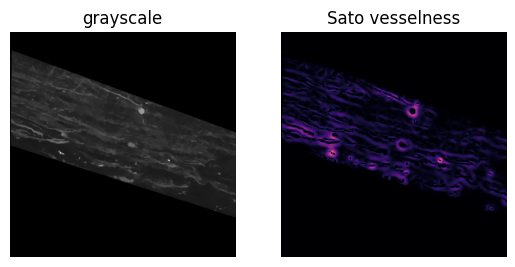

In [147]:
_src = cv2.imread('Basic3.jpg', cv2.IMREAD_COLOR)
_src = cv2.cvtColor(_src, cv2.COLOR_BGR2GRAY)

t0, t1 = filters.threshold_multiotsu(_src, classes=3)
mask = (_src > t0)
vessels = filters.sato(_src, sigmas=range(1, 10)) * mask

_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(_src, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Sato vesselness')

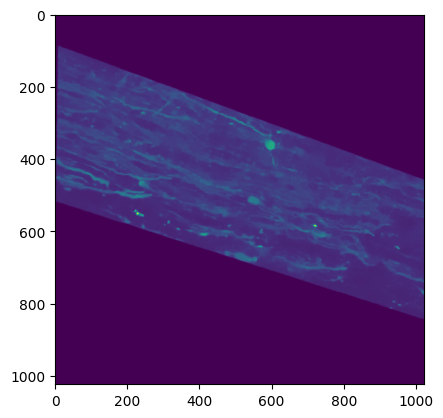

In [168]:
plt.imshow(_src)

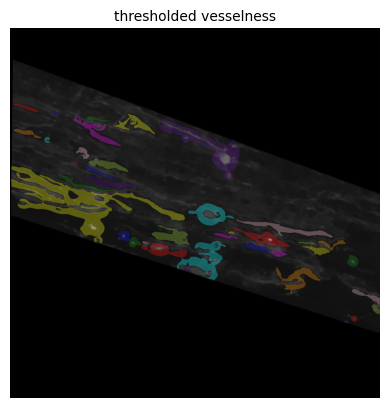

In [185]:
non_zero_vessels = vessels[vessels > 0]

sorted_vessels = np.sort(non_zero_vessels)

thresholded = filters.apply_hysteresis_threshold(vessels, np.percentile(sorted_vessels, 80), np.percentile(sorted_vessels, 95))
labeled = ndi.label(thresholded)[0]

_, ax = plt.subplots()
ax.imshow(color.label2rgb(labeled, _src))
ax.set_axis_off()
_ = ax.set_title('thresholded vesselness')

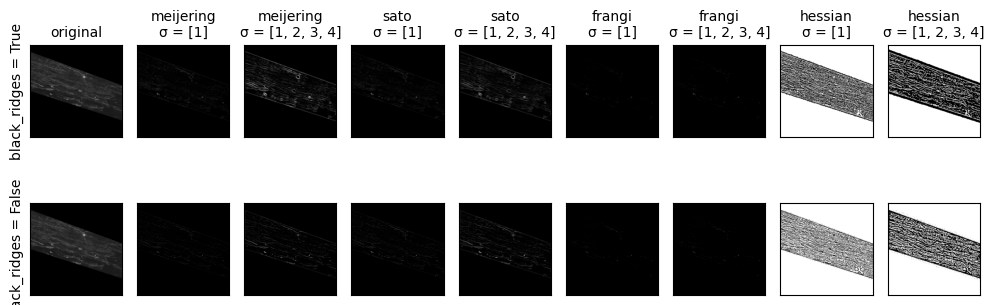

In [149]:
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
import matplotlib.pyplot as plt


def original(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image


image = _src
cmap = plt.cm.gray

plt.rcParams["axes.titlesize"] = "medium"
axes = plt.figure(figsize=(10, 4)).subplots(2, 9)
for i, black_ridges in enumerate([True, False]):
    for j, (func, sigmas) in enumerate([
            (original, None),
            (meijering, [1]),
            (meijering, range(1, 5)),
            (sato, [1]),
            (sato, range(1, 5)),
            (frangi, [1]),
            (frangi, range(1, 5)),
            (hessian, [1]),
            (hessian, range(1, 5)),
    ]):
        result = func(image, black_ridges=black_ridges, sigmas=sigmas)
        axes[i, j].imshow(result, cmap=cmap)
        if i == 0:
            title = func.__name__
            if sigmas:
                title += f"\n\N{GREEK SMALL LETTER SIGMA} = {list(sigmas)}"
            axes[i, j].set_title(title)
        if j == 0:
            axes[i, j].set_ylabel(f'{black_ridges = }')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

## Try for each image in the stack

### Normalization of all images

Usage: Normalize pixel values to a specific range for improved model training. This could be try when we want to trian ML model.

def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr


#Image.fromarray(normalized_image.astype(np.uint8))
normalized_image = np.zeros((z_value, x_value, y_value), dtype=np.uint8)

for i in z_values:
    arr = merged_image[i]
    merged_image[i, :, :] = Image.fromarray(normalize(arr).astype('uint8'))
    
    
plt.imshow(merged_image[4], cmap = 'gray')

### Histogram Equalization

Usage: Enhance image contrast by equalizing pixel intensities.

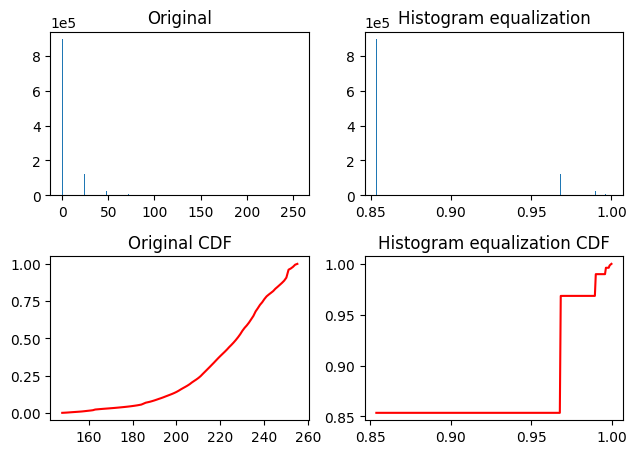

In [23]:
equalized = exposure.equalize_hist(merged_image[4])

fig, ((a, b), (c, d)) = plt.subplots(nrows=2, ncols=2)

plot_hist(a, merged_image[4], title="Original")
plot_hist(b, equalized, title="Histogram equalization")

cdf, bins = exposure.cumulative_distribution(cl1.ravel())
c.plot(bins, cdf, "r")
c.set_title("Original CDF")

cdf, bins = exposure.cumulative_distribution(equalized.ravel())
d.plot(bins, cdf, "r")
d.set_title("Histogram equalization CDF");

fig.tight_layout()

#viewer.add_image(equalized, contrast_limits=[0, 1], name='histeq')

<Figure size 640x480 with 0 Axes>

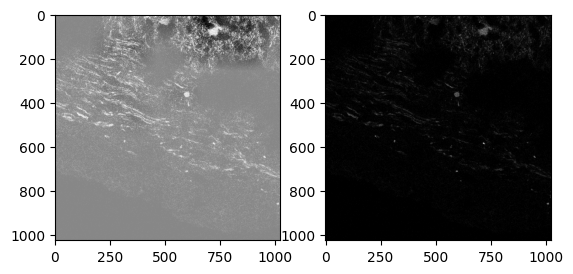

In [43]:
clahe = cv.createCLAHE(clipLimit=200.0, tileGridSize=(10,10))
cl1 = clahe.apply(merged_image[4])

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(nrows=1, ncols=2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(cl1, cmap = 'gray')
axarr[1].imshow(merged_image[4], cmap = 'gray')

In [44]:
cl1.astype(np.uint8)

array([[199, 199, 199, ..., 173, 173, 228],
       [213, 199, 199, ..., 228, 173, 173],
       [199, 199, 199, ..., 246, 228, 246],
       ...,
       [199, 199, 199, ..., 199, 199, 199],
       [199, 199, 199, ..., 199, 199, 199],
       [199, 199, 199, ..., 199, 199, 199]], dtype=uint8)

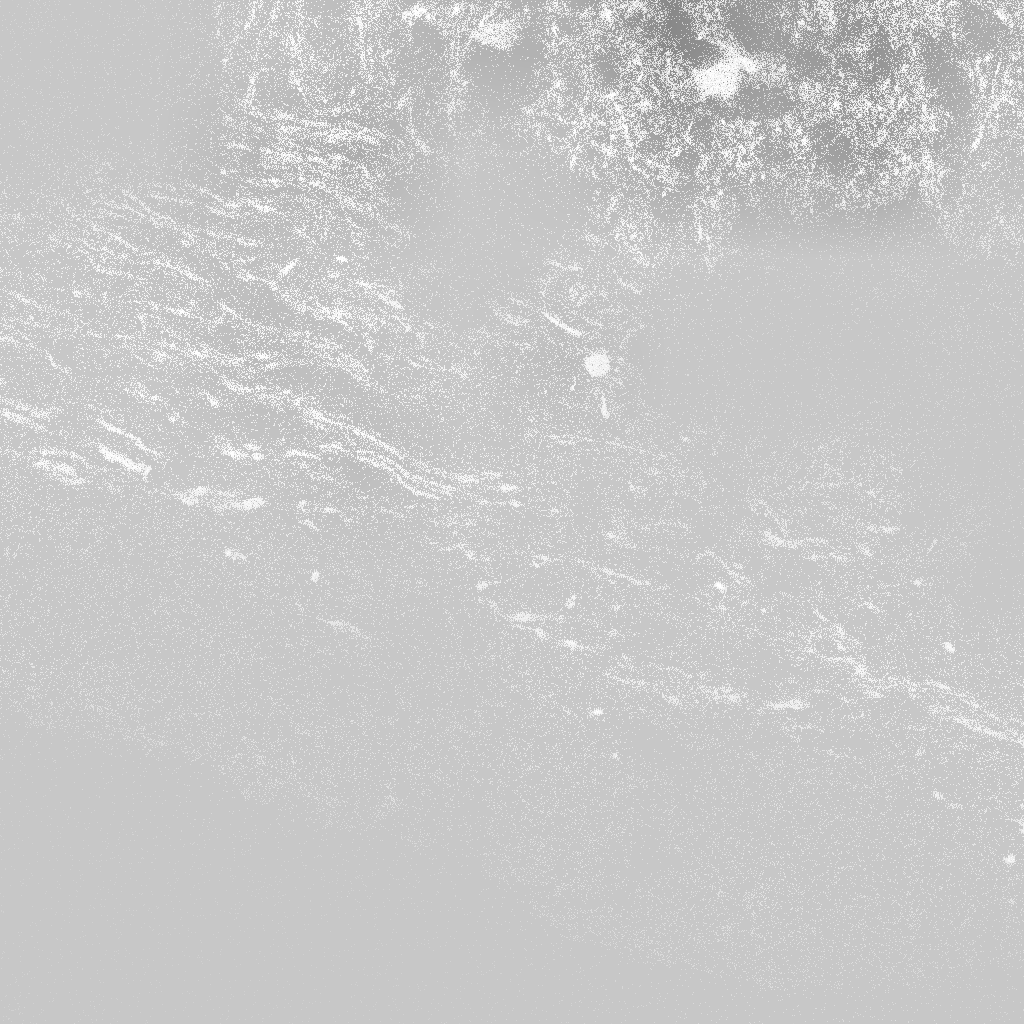

In [45]:
Image.fromarray(cl1.astype(np.uint8))

In [67]:
vmin, vmax = np.quantile(merged_image, q=(0.9, 0.995))

stretched = exposure.rescale_intensity(
    merged_image, 
    in_range=(vmin, vmax), 
    out_range=np.float32
)

viewer.add_image(stretched, contrast_limits=[0, 1], name='stretched')

<Image layer 'stretched [7]' at 0x253edff6590>

### try threholding and segementation

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)

thresholds = filters.threshold_multiotsu(image, classes=3)
cells = image > thresholds[1]

distance = ndi.distance_transform_edt(cells)

local_max_coords = feature.peak_local_max(distance, min_distance=7)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = measure.label(local_max_mask)

segmented_cells = segmentation.watershed(-distance, markers, mask=cells)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(cells, cmap='gray')
ax[0].set_title('Overlapping nuclei')
ax[0].axis('off')
ax[1].imshow(color.label2rgb(segmented_cells, bg_label=0))
ax[1].set_title('Segmented nuclei')
ax[1].axis('off')
plt.show()

## Make them into 3D

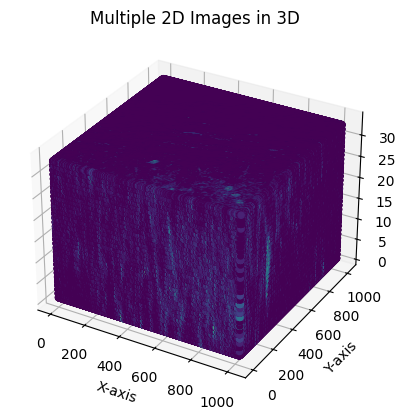

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming selected_image is your LifImage object
# Replace this with the actual method to get pixel values from LifImage
z_values = np.arange(1, 34)
images = [np.array(selected_image.get_frame(z=z_val, t=0, c=1)) for z_val in z_values]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each 2D image as a scatter plot in 3D space
for i, image in enumerate(images):
    x_values, y_values = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    ax.scatter(x_values.ravel(), y_values.ravel(), z_values[i], c=image.ravel(), cmap='viridis', marker='o')

# Customize the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Multiple 2D Images in 3D')

# Show the plot
plt.show()


# After clustering 

we could use connected component to select the axon that we want
https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/